## 批量归一化

* 损失出现在最后，后面出现的层训练较快
* 数据在底部
    * 底部的训练较慢
    * 底部变化会引起整个网络的变化
    * 顶部的层需要重新学习多次
    * 最终导致收敛变慢
* **有没有办法训练底部 并避免变化顶层**

目的：可持续加速深层网络的收敛速度
训练NN时出现的实际问题：
1. 数据预处理的方式通常会对最终结果产生巨大的影响，在使用MLP来预测房价时，使用真实的数据，第一步便是标准化输入特征，使其均值为0，方差为1，这种标准化可以很好地让我们与优化器配合，因为它可以将**参数的量级进行统一**
2. 对于典型的MLP和CNN，当我们训练时，中间层中的变量（例如 MLP的仿射变换输出）可能具有更广的变化范围：不论是沿着从输入到输出的层，跨同一层中的单元，或者随时间的推移，模型参数的训练随着训练更新变幻莫测,BatchNorm的发明者非正式的假设，这些变量分布中的这种偏移可能会阻碍网络的收敛，直观地说，我们可能会猜想吗，如果一个层的可变值是另一层的100倍，这可能需要对学习率进行补偿调整。
3. 更深层的网络很复杂，容易过拟合。这意味着正则化变得更加重要。

BN应用于单个可选层，也可以应用到所有的层，原理如下：在每次迭代中，我们首先规范化输入，即通过减去输入的均值并除以标准差，其中两者均基于当前的小批量处理。 接下来，我们应用比例系数和比例偏移，正是由于这个基于批量统计的标准化，才有了批量规范化的名称。

**只有使用足够大的小批量，批量规范化这种方法才是有效且稳定的。**

在应用BN之后，生成的新的小批量样本具有以下特点:
* 均值为0
* 方差为1

由于单位方差是一个主观的选择，因此我们通常包含拉伸参数（scale）$\lambda$ 和偏移参数(shift)$\beta$,他们的形状与X相同，且他们是需要与其他模型一起学习的参数
由于在训练过程中，中间层的变化幅度不能过于剧烈，而BatchNorm将每一层主动居中，并将他们重新调整为给定的平均值和大小


### 全连接层
通常我们将BN层置于全连接层的仿射变换和激活函数之间
### 卷积层
对于卷积层，我们可以在卷积层之后和非线性激活函数之前应用BN，当卷积有多个输出通道时，我们需要对这些通道的每个输出执行BN，每个通道有自己的Scale和Shift参数，这两个参数都是标量。

## 从0实现

In [1]:
import torch
import torch.nn as nn
import os,sys
sys.path.append(os.path.abspath("../"))
import lmy

/home/anaconda3/envs/lmy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tmp = torch.tensor(
    [
        [
            [1, 1, 1],
            [2, 2, 2]
         ],
        [
            [3, 3, 3],
            [4, 4, 4]
         ]
    ]
,dtype=torch.float)
tmp.shape,tmp.mean(dim=(0,1,2),keepdim=True)

(torch.Size([2, 2, 3]), tensor([[[2.5000]]]))

我们需要将数学原理集成到一个自定义的Layer中，用来处理数据，并将其移动到GPU，分配和初始化变量，跟踪移动平均线等。
我们并不担心在这里自动推断输入形状，因此我们需要指定整个特征的数量。

In [2]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        """初始化BatchNorm类,继承nn.Module类

        Args:
            num_features (int): 特征数量
            num_dims (int): 特征维度
        """
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        elif num_dims == 4:
            shape = (1, num_features, 1, 1)

        # 求参与梯度和迭代的Scale与Shift参数，分别初始化为1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    @staticmethod
    def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
        # 通过is_grad_enable()来判断当前模式是训练模式还是预测模式。
        if not torch.is_grad_enabled():
            # 在预测模式下的计算
            X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
        else:
            # 训练模式
            assert len(X.shape) in (2, 4)
            if len(X.shape) == 2:
                # 当二维表示全连接层上使用 BN
                mean = X.mean(dim=0)  # 计算所有样本的特征均值
                var = ((X - mean) ** 2).mean(dim=0)
            else:
                # 当维数为4 表示在卷积上使用BN
                mean = X.mean(dim=(0, 2, 3), keepdims=True)
                var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdims=True)
            # 训练模式下，使用当前均值和方差做标准化
            X_hat = (X - mean) / torch.sqrt(var + eps)
            # 更新移动平均的均值和方差
            moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
            moving_var = momentum * moving_var + (1.0 - momentum) * var
        Y = gamma * X_hat + beta
        return Y, moving_mean.data, moving_var.data

    def forward(self, x):
        # 如果X不在内存上，将moving_mean和moving_var复制到与X相同的显存上
        if self.moving_mean.device != x.device:
            self.moving_mean = self.moving_mean.to(x.device)
            self.moving_var = self.moving_var.to(x.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = self.batch_norm(
            x, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9)
        return Y

### 使用BN的LeNet

FashionMNIST数据集加载成功，训练集大小:60000,测试集大小:10000,数据集shape:torch.Size([1, 28, 28])
训练设备[device(type='cuda', index=0)]


100%|██████████| 10/10 [00:52<00:00,  5.24s/epoch]

loss:25.934%,train_acc:90.512%,test_acc:87.700%)


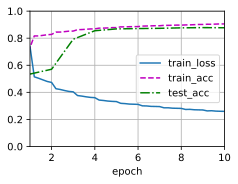

In [5]:
LeNet = nn.Sequential(
    nn.Conv2d(1, 6, 5), BatchNorm(6, 4),nn.Sigmoid(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6,out_channels=16,kernel_size=5), BatchNorm(16, 4),nn.Sigmoid(),
    nn.AvgPool2d(2, stride=2),nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
    )

lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = lmy.loadFashionMnistData(batch_size)
lmy.train_GPU(LeNet,train_iter,test_iter,num_epochs=num_epochs,lr=lr)

### 简洁实现

FashionMNIST数据集加载成功，训练集大小:60000,测试集大小:10000,数据集shape:torch.Size([1, 28, 28])
训练设备[device(type='cuda', index=0)]


100%|██████████| 10/10 [00:48<00:00,  4.89s/epoch]

loss:25.949%,train_acc:90.478%,test_acc:88.840%)


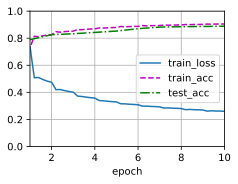

In [3]:
LeNet1 = nn.Sequential(
    nn.Conv2d(1, 6, 5),nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
    )

lr, num_epochs, batch_size = 1.0, 10, 256
lmy.train_GPU_FASHION_MNIST(LeNet1,num_epochs,lr,batch_size,net_name="LeNet with BN")


FashionMNIST数据集加载成功，训练集大小:60000,测试集大小:10000,数据集shape:torch.Size([1, 28, 28])
训练设备[device(type='cuda', index=0)]


100%|██████████| 10/10 [00:46<00:00,  4.70s/epoch]

loss:50.625%,train_acc:80.338%,test_acc:80.430%)


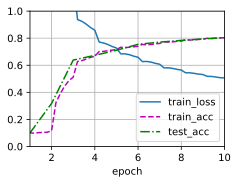

In [4]:
LeNet2 = nn.Sequential(
    nn.Conv2d(1, 6, 5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
    )

lr, num_epochs, batch_size = 1.0, 10, 256
lmy.train_GPU_FASHION_MNIST(LeNet2,num_epochs,lr,batch_size,net_name="LeNet without BN")
